<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/Lecture4/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Es 1**

In [2]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

In [6]:
class Autoencoder(torch.nn.Module):
  def __init__(self, input_dim, bottleneck_dim):
    super(Autoencoder, self).__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, bottleneck_dim)
    )
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(bottleneck_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, input_dim)
    )

  def forward(self,x):
    latent = self.encoder(x)
    return self.decoder(latent)

In [7]:
from tqdm import tqdm

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
model = Autoencoder(784, 2).to("cuda")
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    bar = tqdm(dl)
    for digit, _ in bar:
        digit = digit.to("cuda")
        digit = digit.view(digit.shape[0], 28 * 28)

        recostructed = model(digit)

        loss = loss_fn(recostructed, digit)
        bar.set_description(f"Loss: {loss.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Loss: 0.3753: 100%|██████████| 1875/1875 [00:23<00:00, 79.78it/s]


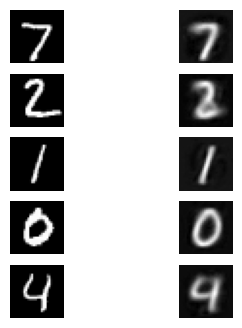

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 2, figsize=(4, 4))

for i in range(5):
    digit = test_mnist[i][0].view(1, 28 * 28).to("cuda")
    recostructed = model(digit).cpu().detach().numpy().reshape(28, 28)

    axes[i][0].imshow(test_mnist[i][0].reshape(28, 28), cmap="gray")
    axes[i][1].imshow(recostructed, cmap="gray")

    axes[i][0].axis("off")
    axes[i][1].axis("off")



plt.show()

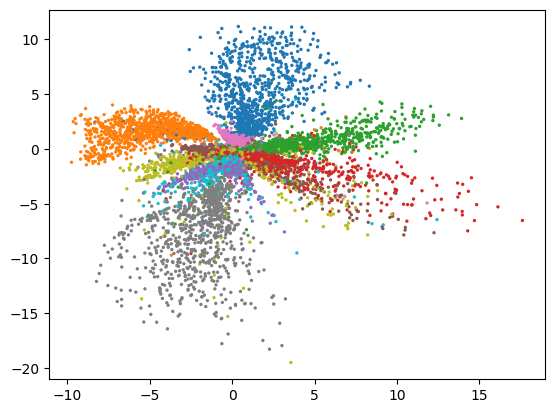

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
dl = torch.utils.data.DataLoader(test_mnist, batch_size=32)

for digit, cls in dl:
    digit = digit.view(-1, 28 * 28).to("cuda")
    latent = model.encoder(digit).cpu().detach().numpy()

    ax.scatter(latent[:, 0], latent[:, 1], c=cls, cmap="tab10", s=2)

plt.show()

# **Es 2**

In [3]:
class VariationalAutoencoder(torch.nn.Module):
  def __init__(self, input_dim, bottleneck_dim):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU()
    )

    self.mu_head = torch.nn.Linear(300, bottleneck_dim)
    self.std_head = torch.nn.Linear(300, bottleneck_dim)

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(bottleneck_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, input_dim)
    )

  def encode(self,x):
    x = self.encoder(x)
    mu = self.mu_head(x)
    std = torch.abs(self.std_head(x))
    return mu, std

  def generate(self, mu, std):
      p = torch.distributions.Normal(mu, std)
      z = p.rsample()
      return self.decoder(z)

  def forward(self, x, return_kl=False):
    mu, std = self.encode(x)

    reconstructed = self.generate(mu,std)

    if return_kl:
      kl = 0.5 * (std**2 + mu.pow(2) - 1 - torch.log(std**2)).sum(dim=1).mean(dim=0)
      return reconstructed, kl

    return reconstructed

In [6]:
from tqdm import tqdm
dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
vae = VariationalAutoencoder(784, 2).to("cuda")
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
alpha = 1
beta = 0.005

for epoch in range(3):
    bar = tqdm(dl)
    for digit, _ in bar:
        digit = digit.to("cuda")
        digit = digit.view(digit.shape[0], 28 * 28)

        recostructed, KL = vae(digit, True)

        error = loss_fn(recostructed, digit)
        loss = (alpha*error + beta*KL)
        bar.set_description(f"Loss: {loss.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


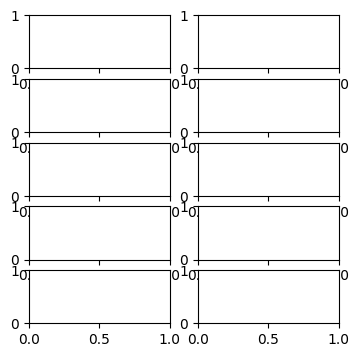

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 2, figsize=(4, 4))

for i in range(5):
    digit = test_mnist[i][0].view(1, 28 * 28).to("cuda")
    recostructed = vae(digit).cpu().detach().numpy().reshape(28, 28)

    axes[i][0].imshow(test_mnist[i][0].reshape(28, 28), cmap="gray")
    axes[i][1].imshow(recostructed, cmap="gray")

    axes[i][0].axis("off")
    axes[i][1].axis("off")



plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


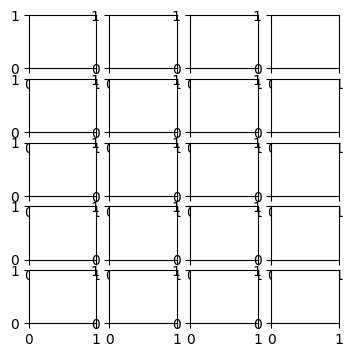

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 4, figsize=(4, 4))

for i in range(5):
    digit = test_mnist[i][0].view(1, 28 * 28).to("cuda")
    mu, std = vae.encode(digit)
    recostructed1 = vae.generate(mu, std).cpu().detach().numpy().reshape(28, 28)
    recostructed2 = vae.generate(mu, std).cpu().detach().numpy().reshape(28, 28)
    recostructed3 = vae.generate(mu, std).cpu().detach().numpy().reshape(28, 28)

    axes[i][0].imshow(test_mnist[i][0].reshape(28, 28), cmap="gray")
    axes[i][1].imshow(recostructed1, cmap="gray")
    axes[i][2].imshow(recostructed2, cmap="gray")
    axes[i][3].imshow(recostructed3, cmap="gray")

    axes[i][0].axis("off")
    axes[i][1].axis("off")
    axes[i][2].axis("off")
    axes[i][3].axis("off")


plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
dl = torch.utils.data.DataLoader(test_mnist, batch_size=32)

for digit, cls in dl:
    digit = digit.view(-1, 28 * 28).to("cuda")
    mu, std = vae.encode(digit)
    mu = mu.cpu().detach().numpy()

    ax.scatter(mu[:, 0], mu[:, 1], c=cls, cmap="tab10", s=2)

plt.show()